### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

In [2]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python moviepy pydot
# !pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [3]:
# Import the required libraries.
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [4]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 1: Visualize the Data with its Labels</font>**

In the first step, we will visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:

*   **`50`** Action Categories

*   **`25`** Groups of Videos per Action Category

*   **`133`** Average Videos per Action Category

*   **`199`** Average Number of Frames per Video

*   **`320`** Average Frames Width per Video

*   **`240`** Average Frames Height per Video

*   **`26`** Average Frames Per Seconds per Video

For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

In [5]:
#Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the Dataset
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

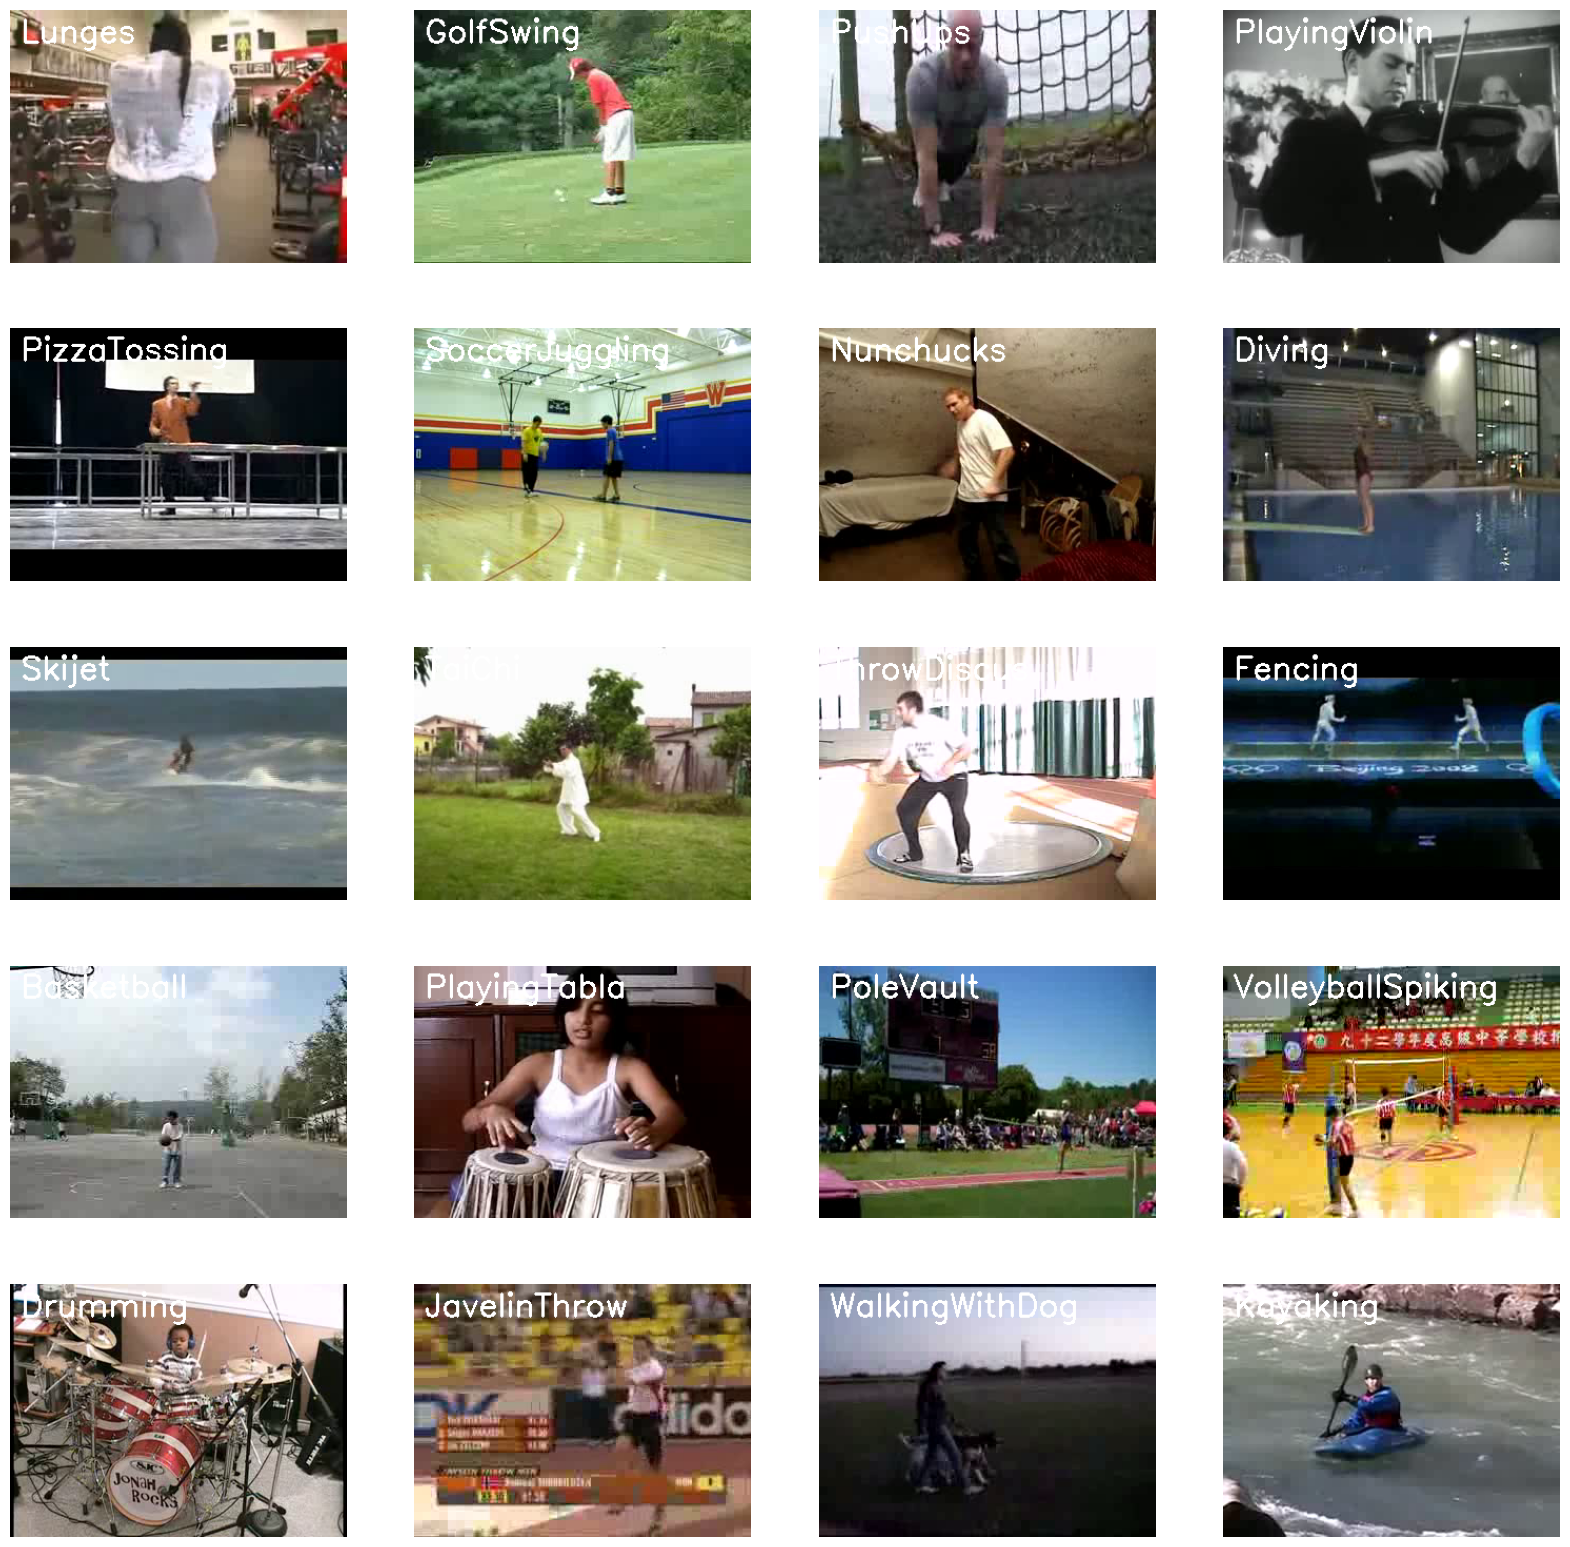

In [6]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [7]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20      # Skip Frame Technique Use Here

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Punch", "Nunchucks", "RopeClimbing", "Fencing", "JavelinThrow", "ThrowDiscus", "RockClimbingIndoor"]

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [9]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

# **Code for background Subtraction**

In [10]:
!pip install ultralytics
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 36.9 MB/s eta 0:00:00


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd '/content/drive/MyDrive/Colab Notebooks/R&D'

/content/drive/MyDrive/Colab Notebooks/R&D


In [13]:
!ls

'Copy of LRCN_Model_for_Action_Recognition.ipynb'
 LRCN_model___Date_Time_2024_11_05__07_42_48___Loss_0.5086085200309753___Accuracy_0.7843137383460999.h5
 LRCN_model___Date_Time_2024_11_05__08_01_19___Loss_0.49919140338897705___Accuracy_0.8442623019218445.h5
 LRCN_model___Date_Time_2024_11_05__14_55_22___Loss_0.45947709679603577___Accuracy_0.813725471496582.h5
 LRCN_model___Date_Time_2024_11_05__15_06_06___Loss_0.5464060306549072___Accuracy_0.7254902124404907.h5
 LRCN_model___Date_Time_2024_11_09__05_32_35___Loss_0.2865406572818756___Accuracy_0.8888888955116272.h5
 LRCN_model___Date_Time_2024_11_25__05_47_19___Loss_0.7355371713638306___Accuracy_0.8201377391815186.h5
 LRCN_model___Date_Time_2024_11_25__06_24_27___Loss_0.7355371713638306___Accuracy_0.7845572233200073.h5
 LRCN_model___Date_Time_2024_11_25__06_34_42___Loss_0.7933884263038635___Accuracy_0.7139982581138611.h5
 LRCN_Model_for_Action_Recognition.ipynb
 person_masks
 prediction_output.txt
 __temp__.mp4
 video1.mp4
 video1_test_

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [14]:
from ultralytics import YOLO

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20  # Skip Frame Technique Use Here

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/UCF50"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["Punch", "Nunchucks", "RopeClimbing", "Fencing", "JavelinThrow", "ThrowDiscus", "RockClimbingIndoor"]

# Load YOLOv8 segmentation model
model = YOLO('yolov8m-seg.pt')  # Adjust the path to your model file

# Create a directory to store the person masks
os.makedirs("/content/drive/MyDrive/Colab Notebooks/R&D/person_masks", exist_ok=True)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [15]:
def frames_extraction(video_path):
    '''
    This function extracts the required frames from a video after resizing, normalizing,
    and applying segmentation to keep only the person.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if the video frame is not successfully read then break the loop
        if not success:
            break

        # Segment the frame to extract only the person using YOLOv8
        mask_image = np.zeros_like(frame, dtype=np.float32)  # Use float32 for mask image
        results = model(frame)

        # Check if masks and boxes are present in the results
        if results[0].masks is not None and results[0].boxes is not None:
            masks = results[0].masks  # Segmentation masks
            boxes = results[0].boxes  # Bounding boxes

            # Loop through all detections
            for i, (mask, box) in enumerate(zip(masks.data, boxes)):
                label = results[0].names[int(box.cls)]  # Get the label of the detected object

                # Check if the object is a person
                if label == 'person':
                    # Resize mask to the frame size
                    mask_resized = cv2.resize(mask.cpu().numpy(), (frame.shape[1], frame.shape[0]))

                    # Convert mask to binary and multiply with the original frame to extract the person
                    person_segmented = np.multiply(frame, mask_resized[..., np.newaxis])

                    # Add this mask to the mask_image for all persons
                    mask_image += person_segmented

            # Clip values to valid range [0, 255] and convert to uint8 for saving
            mask_image = np.clip(mask_image, 0, 255).astype(np.uint8)

            # Resize the segmented person frame to the specified dimensions
            resized_frame = cv2.resize(mask_image, (IMAGE_HEIGHT, IMAGE_WIDTH))

            # Normalize the resized frame by dividing it with 255 so that each pixel value lies between 0 and 1
            normalized_frame = resized_frame / 255.0

            # Append the normalized frame into the frames list
            frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [17]:
def create_dataset():
    '''
    This function extracts the data of the selected classes and creates the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels, and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [18]:
# Now you can call create_dataset() to generate the pre-processed dataset with segmented frames.
features, labels, video_files_paths = create_dataset()
print("Dataset created successfully.")

Streaming output truncated to the last 5000 lines.
Speed: 2.3ms preprocess, 17.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 17.7ms
Speed: 2.4ms preprocess, 17.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 16.4ms
Speed: 6.4ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 18.7ms
Speed: 2.3ms preprocess, 18.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 17.8ms
Speed: 2.4ms preprocess, 17.8ms inference, 0.4

Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [19]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [39]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True)
                                                                            #,random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the LRCN Approach</font>**

### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [40]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'gelu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [41]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_13                  │ (None, 20, 64, 64, 16)      │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 20, 16, 16, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 20, 16, 16, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 20, 16, 16, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 20, 4, 4, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 20, 4, 4, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 20, 4, 4, 64)        │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 20, 2, 2, 128)       │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 20, 1, 1, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 20, 1, 1, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 20, 128)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             2

 Total params: 118,279 (462.03 KB)

 Trainable params: 118,279 (462.03 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

In [ ]:
# Plot the structure of the contructed LRCN model.
# plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, TopKCategoricalAccuracy

# Set a specific learning rate for the Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Adjust this value as needed

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [43]:
# Compile the model and specify loss function, optimizer, and metrics
# LRCN_model = create_LRCN_model()
LRCN_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        "accuracy",                          # Standard accuracy metric
        Precision(name="precision"),         # Precision metric
        Recall(name="recall"),               # Recall metric
        TopKCategoricalAccuracy(k=3, name="top_3_accuracy")  # Top-3 Accuracy
    ]
)

# Start training the model
LRCN_model_training_history = LRCN_model.fit(
    x=features_train,
    y=labels_train,
    epochs=100,
    batch_size=4,
    shuffle=True,
    validation_split=0.20,
    callbacks=[early_stopping_callback]
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 719ms/step - accuracy: 0.1814 - loss: 1.8481 - precision: 0.1533 - recall: 0.0019 - top_3_accuracy: 0.5466 - val_accuracy: 0.4505 - val_loss: 1.4703 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_3_accuracy: 0.8462
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3956 - loss: 1.5355 - precision: 0.5536 - recall: 0.0719 - top_3_accuracy: 0.7462 - val_accuracy: 0.3956 - val_loss: 1.5551 - val_precision: 0.3333 - val_recall: 0.1648 - val_top_3_accuracy: 0.8352
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.4547 - loss: 1.3598 - precision: 0.7165 - recall: 0.2524 - top_3_accuracy: 0.8056 - val_accuracy: 0.5495 - val_loss: 1.1826 - val_precision: 0.6481 - val_recall: 0.3846 - val_top_3_accuracy: 0.8901
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5499 - loss: 1.2063 - precision: 0.7655 - recall: 0.3833 - top_3_accuracy: 0.8439 - val_accuracy: 0.5275 - val_loss: 1.1885 - val_p

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [44]:
# # Evaluate the trained model.
# # model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)
# # Evaluate the model on test data
# evaluation_results = LRCN_model.evaluate(features_test, labels_test)

# # Get precision and recall
# precision = evaluation_results[LRCN_model.metrics_names.index("precision")]
# recall = evaluation_results[LRCN_model.metrics_names.index("recall")]

# # Calculate F1-Score
# f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
# # print(f"F1-Score: {f1_score:.4f}")

# # Print all metric values, including Top-3 Accuracy
# for metric, value in zip(LRCN_model.metrics_names, evaluation_results):
#     print(f"{metric}: {value:.4f}")
# print(f"F1-Score: {f1_score:.4f}")

# Evaluate the model on test data
evaluation_results = LRCN_model.evaluate(features_test, labels_test, verbose=1)

# Map metric names to their corresponding evaluation results
metric_names = LRCN_model.metrics_names  # List of metrics
metrics = dict(zip(metric_names, evaluation_results))  # Map names to values

# # Dynamically fetch Precision and Recall using their keys
# precision_key = next(name for name in metric_names if "precision" in name)
# recall_key = next(name for name in metric_names if "recall" in name)

# precision = metrics[precision_key]
# recall = metrics[recall_key]

# # Compute F1-Score
# f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

# # Display results
# print(f"Evaluation Results:")
# for metric_name, value in metrics.items():
#     print(f"{metric_name}: {value:.4f}")

# print(f"F1-Score: {f1_score:.4f}")

# Debug metrics and manually assign indices
# print("Metrics Names:", metric_names)
# print("Evaluation Results:", evaluation_results)

# Manually assign based on printed indices
precision = evaluation_results[2]  # Replace with actual index for "precision"
recall = evaluation_results[3]     # Replace with actual index for "recall"

# Compute F1-Score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
print(f"F1-Score: {f1_score:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8188 - loss: 0.5447 - precision: 0.8281 - recall: 0.7930 - top_3_accuracy: 0.9503
F1-Score: 0.7959


## **Model Performance**

Without Background Subtraction - accuracy: 0.9113 - loss: 0.4420 - precision: 0.9137 - recall: 0.9113 - F1-Score: 0.9175 - top_3_accuracy: 0.9860

With Background Subtraction - accuracy: 0.8188 - loss: 0.5447 - precision: 0.8281 - recall: 0.7930 - F1-Score: 0.7959 - top_3_accuracy: 0.9503




#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [45]:
# Get the loss and accuracy from model_evaluation_history.
accuracy, loss, precision, recall, top_3_accuracy = evaluation_results

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{loss}___Accuracy_{accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


In [46]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

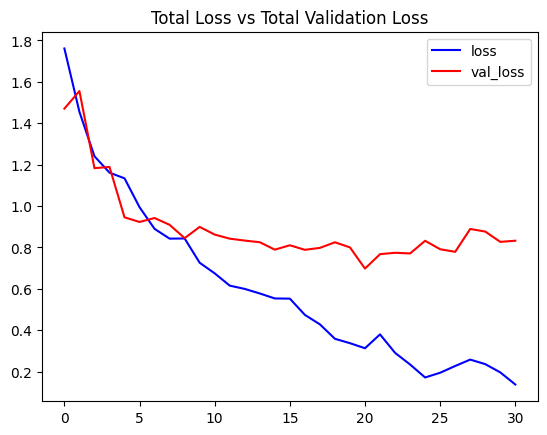

In [47]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

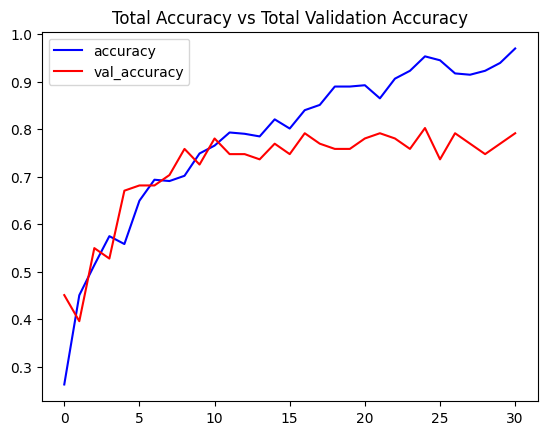

In [48]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **<font style="color:rgb(134,19,348)">Step 5: Test the  Model</font>**


### **<font style="color:rgb(134,19,348)">Create a Function To Perform a Single Prediction on Videos</font>**


In [49]:
import os

def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis=0))[0]

    # Get the index of the class with the highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

    # Store the output (e.g., prediction) in the same directory as the input video
    video_directory = os.path.dirname(video_file_path)
    output_file_path = os.path.join(video_directory, 'prediction_output.txt')

    # Write the predicted class and confidence to a text file
    with open(output_file_path, 'w') as f:
        f.write(f'Action Predicted: {predicted_class_name}\n')
        f.write(f'Confidence: {predicted_labels_probabilities[predicted_label]}\n')

    print(f"Prediction saved at: {output_file_path}")

### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**


In [50]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
input_video_file_path = '/content/drive/MyDrive/Colab Notebooks/R&D/video1.mp4'

# Perform Single Prediction on the Test Video
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Action Predicted: Punch
Confidence: 0.9949212670326233
Prediction saved at: /content/drive/MyDrive/Colab Notebooks/R&D/prediction_output.txt


In [51]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
input_video_file_path = '/content/drive/MyDrive/Colab Notebooks/R&D/video2.mp4'

# Perform Single Prediction on the Test Video
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Action Predicted: Punch
Confidence: 0.9665786027908325
Prediction saved at: /content/drive/MyDrive/Colab Notebooks/R&D/prediction_output.txt


# **Conclusion**

Training with background-subtracted (segmented) videos appears to improve the model's robustness in recognizing actions across varied inputs. Although the initial accuracy and loss metrics show slightly lower performance with background subtraction, in practical scenarios (like your test case), it has proven advantageous. Therefore, using background subtraction for HAR models can improve the model’s flexibility and reliability in real-world applications, particularly for distinct actions in dynamic backgrounds.